# Exploring Grid Flexibility

This data exploration is inspired by Saul Griffith's *Electrify*: "Electrifying the whole household roughly triples the amount of electricity it requires...While this might initially seem like a problem, adding thermal loads and connecting electric vehicles to the house provides greater opportunity for these machines to take turns sucking up some sunshine. This technique is called 'demand response.'" (p.88)

As an engineer learning about the energy space, the goal of this exploratory notebook is to facilitate conversations with folks who are dealing with these problems in their day-to-day work, to start learning about some of the freely available grid data and to apply simple scheduling algorithms to it.

The final "Resources Scheduled" chart is inspired by Griffith's flexible load profile chart on page 89. Here, I attempt to approach it algorithmically by getting price and energy output data from the NYISO grid (via [GridStatus](https://docs.gridstatus.io/en/latest/index.html)) and scheduling home energy resources during windows of time where:
1. price is lowest
2. renewable energy output (excluding wind and hydro) is the highest

## Get and display price data for a given day
LMP is Locational Marginal Price (see GridStatus [documentation](https://docs.gridstatus.io/en/latest/lmp.html))

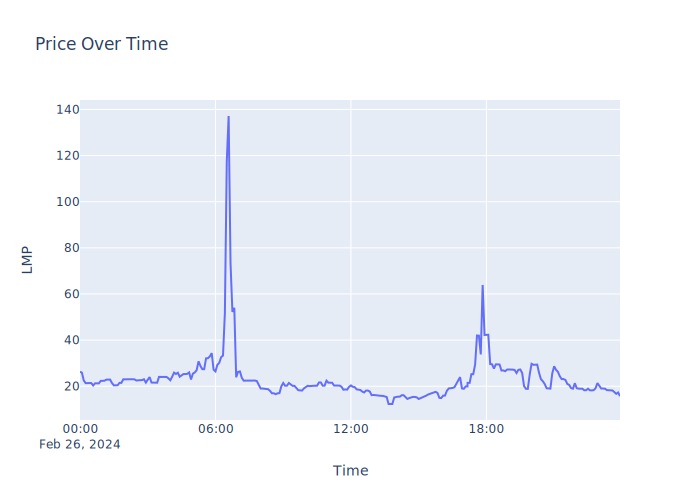

In [1]:
import gridstatus
from chart_utils import show_line_chart

def get_nyiso_price_data_by_location(date, location):
    nyiso = gridstatus.NYISO()
    lmp = nyiso.get_lmp(date=date, market="REAL_TIME_5_MIN")
    lmp_col_subset = lmp[["Time", "Location", "LMP"]]
    lmp_subset_filtered = lmp_col_subset[lmp_col_subset["Location"] == location]
    return lmp_subset_filtered

price_data_by_location = get_nyiso_price_data_by_location("February 26, 2024", "GENESE");
show_line_chart(price_data_by_location, "Time", "LMP", "Price Over Time")

## Schedule resources in parallel, at windows of time with lowest price

We assume we want to keep resources "on" continously, below we directly find the most optimal window for each resource. The optimal window is found by calculating a minimum rolling average across 5-minute intervals. Window length is the number of hours a resource has been assigned.

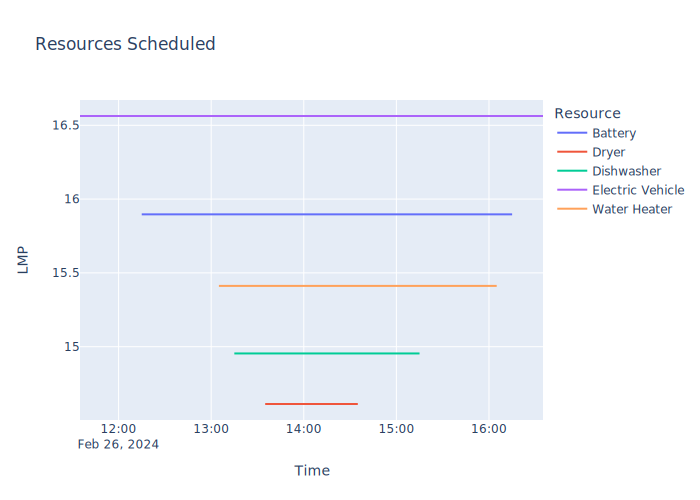

In [2]:
import pandas as pd
from allocator import to_resources
from allocator import allocate_resources_by_rolling_average
from chart_utils import show_line_chart_with_color

def get_resources():
    return to_resources([
        {"name": "Battery", "hours": 4, "priority": 1},
        {"name": "Dryer", "hours": 1, "priority": 2},
        {"name": "Dishwasher", "hours": 2, "priority": 3},
        {"name": "Electric Vehicle", "hours": 5, "priority": 4},
        {"name": "Water Heater", "hours": 3, "priority": 5},
    ])

allocated_resources = allocate_resources_by_rolling_average(get_resources(), price_data_by_location)
allocated_resources_df = pd.DataFrame(allocated_resources, columns=["Resource", "Time", "LMP"])
show_line_chart_with_color(allocated_resources_df, 
                          "Resource", 
                          "Time", 
                          "LMP", 
                          "Resources Scheduled")

Now let's zoom out to see exactly where the above windows got scheduled relative to our original price graph.

We can see below that the windows of time with the highest price remain open, with nothing scheduled. 

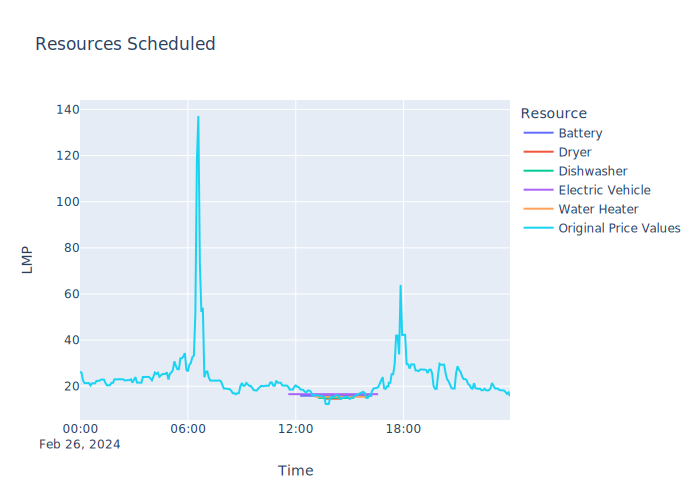

In [3]:
price_data_by_location_copy = price_data_by_location.copy()
price_data_by_location_copy["Resource"] = "Original Price Values"
show_line_chart_with_color(pd.concat([allocated_resources_df, 
                                      price_data_by_location_copy],
                                      ignore_index=True), 
                           "Resource",
                           "Time",
                           "LMP",
                           "Resources Scheduled")

## Get data for NYISO "Other Renewables" Output (MW)
According to [NYISO Real-Time Dashboard](https://www.nyiso.com/real-time-dashboard), Other Renewables consists of: Solar Energy, Energy Storage Resources, Methane, Refuse, Wood (Wind and Hydro are separate categories).

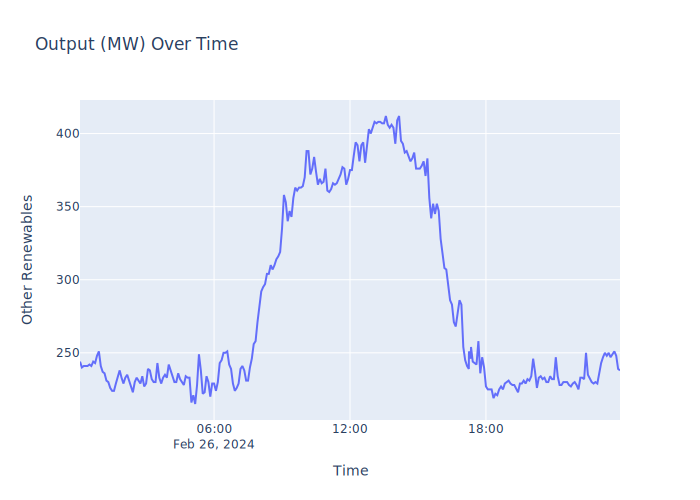

In [4]:
def get_other_renewable_energy_output():
    nyiso = gridstatus.NYISO()
    energy_output = nyiso.get_fuel_mix(start="February 26, 2024", end="February 27, 2024")
    energy_output_col_subset = energy_output[["Time", "Other Renewables"]]
    energy_output_filtered = energy_output_col_subset[energy_output_col_subset["Time"] < "February 27, 2024"]
    return energy_output_filtered
    
other_renewable_energy_output = get_other_renewable_energy_output()
show_line_chart(other_renewable_energy_output, "Time", "Other Renewables", "Output (MW) Over Time")

## Average output MW in one-hour chunks

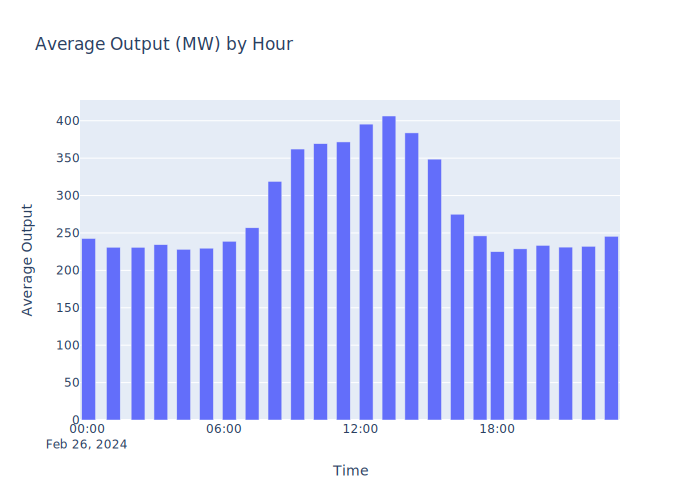

In [5]:
import numpy as np
from chart_utils import show_bar_chart
from chart_utils import get_average_in_column

def get_data_averaged_by_hour(data_by_location, column_to_average):
    data_averaged_by_hour = [];
    num_chunks = len(data_by_location) / 12 # 12 represents number of 5 minute chunks in an hour, our intervals in data
    for chunk in np.array_split(data_by_location, num_chunks):
        data_averaged_by_hour.append([chunk["Time"].iloc[0], get_average_in_column(chunk, column_to_average)])
    return data_averaged_by_hour
    
energy_output_averaged_by_hour = get_data_averaged_by_hour(other_renewable_energy_output, "Other Renewables")
show_bar_chart(energy_output_averaged_by_hour, "Time", "Average Output", "Average Output (MW) by Hour")

## Schedule resources by priority, at windows of time with most energy output

Saul Griffith writes: "In our current energy landscape, electricity is cheap at night, because demand is low and it is too hard to turn off the fossil fuel plants...In the future, the cheap electricity will be in the early afternoon because of solar-we'll just need to change the timers." (p.88)

Given solar energy output is intermittent, we want to use it when it's available. Scheduling resources based on highest "Other Renewables" output has the effect of scheduling most of our resources around noon (the noon-time peak in the NYISO data likely corresponds to when solar energy is most abundant, the sun is shining, but unfortunately this isn't explicit in the data itself).

We can see below that the windows of time with lowest energy output do not have any resources scheduled. 

**Note**: In this simple implementation we do not consider that the resources could be scheduled in parallel (see last chart for parallel scheduling)

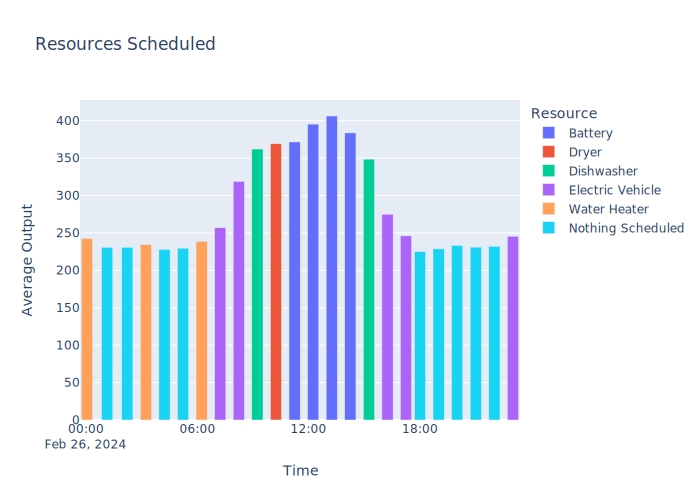

In [7]:
from operator import itemgetter
from allocator import allocate_resources
from chart_utils import show_bar_chart_with_color

def allocate_resources_by_highest_energy_output(resources, energy_output_averaged_by_hour):
    energy_output_averaged_by_hour_sorted = sorted(energy_output_averaged_by_hour, key=itemgetter(1), reverse=True)
    return allocate_resources(resources, energy_output_averaged_by_hour_sorted)

renewable_data_with_resources_allocated = allocate_resources_by_highest_energy_output(get_resources(), energy_output_averaged_by_hour)
show_bar_chart_with_color(renewable_data_with_resources_allocated, 
                          "Resource", 
                          "Time", 
                          "Average Output", 
                          "Resources Scheduled")

## Schedule resources by priority and in parallel, at windows of time with most energy output

If we provide a demand value to each of the resources, we can expand the above algorithm to schedule resources in parallel - each resource then eats up a chunk of the energy available in a given hour.

**Note**: As the energy output data obtained from the grid is in megawatts, it's obvious that an Electric Vehicle isn't going to consume 250 megawatts per hour so we have a significant scale mismatch here - for scheduling demonstration purposes we assume the demand and output values are on same scale (we could imagine that the energy output represents output from rooftop solar).

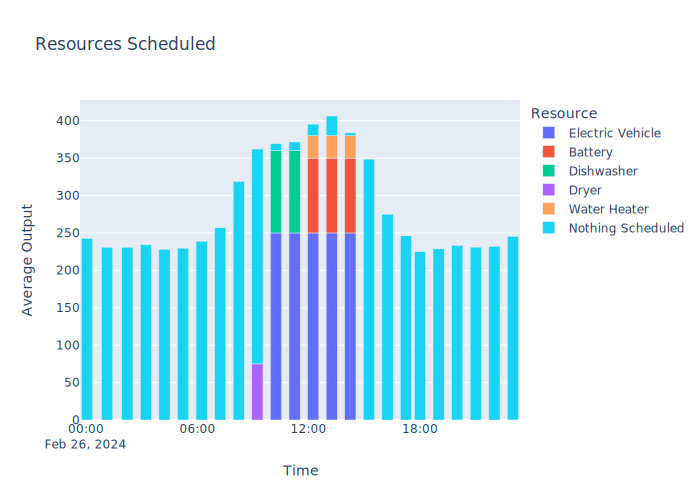

In [8]:
from allocator import allocate_resources_parallel
from chart_utils import show_bar_chart_with_color_sorted

def allocate_parallel_resources_by_highest_energy_output(resources, energy_output_averaged_by_hour):
    energy_output_averaged_by_hour_sorted = sorted(energy_output_averaged_by_hour, key=itemgetter(1), reverse=True)
    return allocate_resources_parallel(resources, energy_output_averaged_by_hour_sorted)

def get_resources_with_demand():
    return to_resources([
        {"name": "Battery", "hours": 3, "priority": 2, "demand_per_hour": 100},
        {"name": "Dryer", "hours": 1, "priority": 4,  "demand_per_hour": 75},
        {"name": "Dishwasher", "hours": 2, "priority": 3,  "demand_per_hour": 110},
        {"name": "Electric Vehicle", "hours": 5, "priority": 1,  "demand_per_hour": 250},
        {"name": "Water Heater", "hours": 3, "priority": 5,  "demand_per_hour": 30},
    ])

renewable_data_with_resources_allocated = allocate_parallel_resources_by_highest_energy_output(
    get_resources_with_demand(), energy_output_averaged_by_hour)
show_bar_chart_with_color_sorted(renewable_data_with_resources_allocated, 
                                 "Resource",
                                 "Time",
                                 "Average Output",
                                 "Priority",
                                 "Resources Scheduled")

## Limitations / Questions
* Resources likely need to provide option for running continuously or prefer certain times of day
* Resources likely need to have option for "depending on" another resources, i.e. only run dryer when washing machine has already run
* The start and end times of resources likely need to be more granular (i.e. resource may be "on" for 1.5 hours instead of 1). This is currently handled in the version where we schedule by price but not where we schedule by energy output.
* Scheduling loads can be done by price or by energy output, can it be assumed that price will always be low when energy output is highest?
* How does energy output look on the day itself when values are not yet known? We can use a mix of current data and prediction based on historical data?
* We might want to base algorithm on expected energy output for a given day since it may be easier to predict that than price? Is this actually true for energy markets?

### References: 
1. Griffith, S. (2022). *Electrify: An Optimist’s Playbook for Our Clean Energy Future*. MIT Press.
2. https://medium.com/@si.a.arkin/my-experiences-of-pulling-historical-energy-price-data-via-gridstatus-2cf96e7a7505
3. https://github.com/kmax12/gridstatus
4. https://www.nyiso.com/real-time-dashboard